In [10]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import joblib
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_score, HalvingGridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.patches as patches  # extra code – for the curved arrow
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
import lightgbm as lgb
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

warnings.filterwarnings('ignore')

In [11]:
%matplotlib inline

In [12]:
X_train, y_train, X_test, y_test = joblib.load('data_FAA/data.pkl')
redo_grid_search = 1
cm = 0

In [13]:
if redo_grid_search:
  PARAMETERS = {'eta': [0.05],
                "subsample": [1], 
                'max_depth': [8, 10],
                'n_estimators': [600, 1000],
                "colsample_bytree": [0.5,0.88],
                "scale_pos_weight": [1,],
                'reg_alpha': [0,1],
                'reg_lambda': [2,],}

  # HalvingGridSearchCV
  grid_search_xgb = HalvingGridSearchCV(estimator=lgb.LGBMClassifier(),param_grid=PARAMETERS,verbose = 1,
                                                            cv = 10,scoring='accuracy',max_resources=1000,random_state = 0,
                                                            resource='n_samples',n_jobs=-1).fit(X_train.values, y_train.values.ravel())

  lbg_best = grid_search_xgb.best_estimator_
  print("LGBM Classifer")
  print('LGBM Classifer Best Score',grid_search_xgb.best_score_)
  print('LGBM Classifer Best Parmas',grid_search_xgb.best_params_)
  print('LGBM Classifer Accuracy',cross_val_score(lbg_best,X_train.values, y_train.values.ravel(), cv=10).mean())

n_iterations: 3
n_required_iterations: 5
n_possible_iterations: 3
min_resources_: 40
max_resources_: 1000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 128
n_resources: 40
Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate i

In [14]:
y_pred = cross_val_predict(lbg_best, X_train, y_train, cv=20)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_rate=0.05


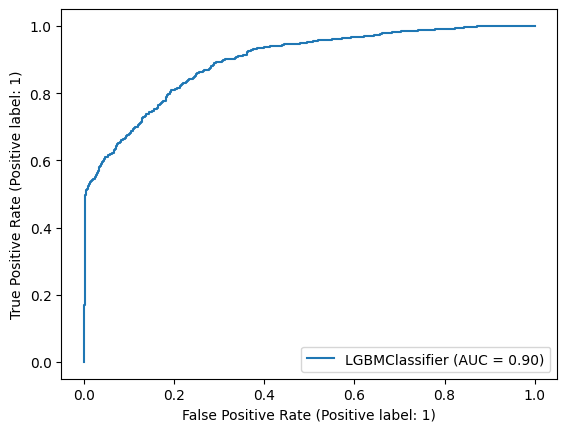

In [15]:
from sklearn.metrics import RocCurveDisplay
lbg_best.fit(X_train, y_train)
RocCurveDisplay.from_estimator(
   lbg_best, X_test, y_test)


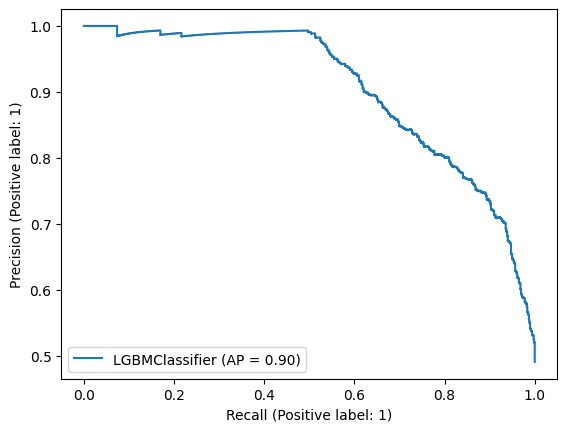

In [16]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(
   lbg_best, X_test, y_test)

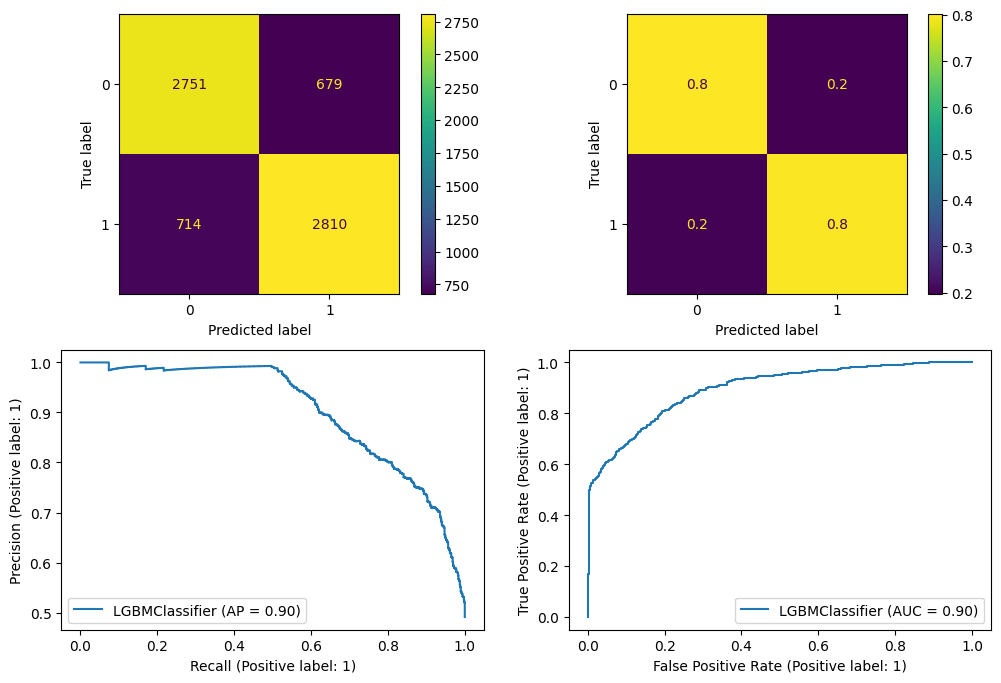

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
RocCurveDisplay.from_estimator(
   lbg_best, X_test, y_test, ax=ax[1, 1])


PrecisionRecallDisplay.from_estimator(
   lbg_best, X_test, y_test, ax=ax[1, 0])

ConfusionMatrixDisplay.from_predictions(y_train, y_pred, ax=ax[0, 0])
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, normalize="true", ax=ax[0, 1])
plt.show()

In [18]:
%%time

# always use same RANDOM_STATE k-folds for comparability between tests, reproducibility
RANDOMSTATE = 42
np.random.seed(RANDOMSTATE)

kfolds = KFold(n_splits=20, shuffle=True, random_state=RANDOMSTATE)

MEAN_RESPONSE=y_train.mean()
def cv_to_raw(cv_val, mean_response=MEAN_RESPONSE):
    return np.expm1(mean_response+cv_val) - np.expm1(mean_response)
	
scores = -cross_val_score(lbg_best, X_train, y_train,
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)
raw_scores = [cv_to_raw(x) for x in scores]
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_

In [19]:
for score, name in zip(lbg_best.feature_importances_, X_train.columns):
    print(f"{score:.3f}{' ':>20}{name.split('__', 1)[1]:>20}")

1368.000                             RoomService
1565.000                               FoodCourt
1424.000                            ShoppingMall
1495.000                                     Spa
1552.000                                  VRDeck
2349.000                             CabinNumber
284.000                              HomePlanet
134.000                               CryoSleep
279.000                             Destination
9.000                                     VIP
2159.000                                   Group
324.000                                Group_id
2256.000                                 Surname
820.000                                    Deck
259.000                               CabinSide
774.000                                     age
260.000                                   total


In [20]:
train_sizes, train_scores, valid_scores = learning_curve(
    lbg_best, X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
# plt.axis([0, 1000, 0.3, 0.9])
# plt.save_fig("underfitting_learning_curves_plot")

plt.show()

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.05 will be ignored. Current value: learning_

In [ ]:
def pandas_preprocessing(X, y_present=True):
  X['PassengerId_split'] = X['PassengerId'].apply(lambda x : str(x).split(sep = '_', maxsplit=1))
  X['Group']= X['PassengerId_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
  X['Group_id']= X['PassengerId_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
  X = X.drop(['PassengerId','PassengerId_split'],axis=1)

  # Split the names
  X['Name_split'] = X['Name'].apply(lambda x : str(x).split(sep = ' ', maxsplit=1))
  X['Surname']= X['Name_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
  X = X.drop(['Name','Name_split'],axis=1)

  # Split the cabins
  X['Cabin_splt'] = X['Cabin'].apply(lambda x : str(x).split(sep = '/'))
  X['Deck']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
  X['CabinNumber']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[1]).astype('float')
  X['CabinSide']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[2])
  X = X.drop(['Cabin','Cabin_splt'],axis=1)

  # Create Total
  numeric_cols = list(X.select_dtypes(include = np.number).columns)
  X['Total'] = sum(X[col] for col in numeric_cols if col not in ["Age", "CabinNumber"])
  X['age'] = pd.cut(x=X['Age'], bins=range(0, 90, 10))
  X['total'] = pd.cut(x=X['Total'], bins=[-35.987, 3598.7, 7197.4, 10796.1, 14394.8, 17993.5, 21592.2, 25190.9, 28789.6, 32388.3, 35987.])
  X = X.drop(['Age', "Total"],axis=1)
  X['age'] = X['age'].astype('str') 
  X['total'] = X['total'].astype('str')
  target = X['Transported']
  target = target.astype(int)
  X = X.drop(['Transported'],axis=1)
  return X, target

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer


warnings.filterwarnings('ignore')

In [ ]:
bol_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    )

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    )


num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
    (bol_pipeline, make_column_selector(dtype_include=bool)),
)

In [ ]:
#----------------For submission----------------
data1= pd.read_csv("data_FAA/train.csv")
data2 = pd.read_csv("data_FAA/evaluation.csv")
data2 = pd.read_csv("data_FAA/evaluation.csv")
data2['Transported'] =-1

data1, y1 = pandas_preprocessing(data1)
data2, y2 = pandas_preprocessing(data2)

data1 = preprocessing.fit_transform(data1)
data2 = preprocessing.transform(data2)

lbg_best.fit(data1, y1)

pred = lbg_best.predict(data2)

pred = pred.astype(bool)
result=pd.read_csv('data_FAA/sample_submission.csv')
result['Transported'] = pred
result.to_csv('submission_lbgm.csv', index=False)